In [472]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.tree import export_text
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [351]:
data = pd.read_csv('./data/listingss.csv')

# Data Preparation

In [352]:
data.shape, data.drop_duplicates().shape

((69351, 18), (69351, 18))

In [353]:
data.isna().sum()

id                                    0
name                                 21
host_id                               0
host_name                             5
neighbourhood_group               69351
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       16780
reviews_per_month                 16780
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           69351
dtype: int64

following columns have missing values:
- name (can be dropped since not relevant for the price inference)
- neighbourhood_group (all records have NaN)
- last_review (let's drop it since we cannot apply a simple imputation approach. One approach would be to investigate the data of the dataset extraction and create a feature number of days between last review and dataset extraction date and predict this for missing values)
- reviews_per_month (let's drop it since we have a column of overall reviews. One approach would be to predict this for missing rows)

In [354]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,106332,"Lovely large room, Bethnal Green",264345,Susie,NaN,Tower Hamlets,51.52874,-0.05396,Private room,55,3,65,2016-06-10,0.47,1,74,0,NaN
1,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56861,-0.11270,Private room,50,1,30,2022-07-15,0.20,2,343,9,NaN
2,284532,COSY STUDIO-FLAT WITH A GREAT VIEW,1481412,Luca,NaN,Tower Hamlets,51.52851,-0.07426,Entire home/apt,90,5,42,2022-01-04,0.34,1,222,1,NaN
3,107048,A Luxury Studio Suite in Clerkenwell,259088,Simon,NaN,Islington,51.52478,-0.10484,Private room,180,4,493,2022-09-02,3.59,5,236,20,NaN
4,284603,Notting Hill church stay in Heaven!,1481851,Tania,NaN,Kensington and Chelsea,51.51464,-0.20004,Entire home/apt,297,14,6,2022-07-04,0.05,1,180,2,NaN


In [357]:
columns = [ 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 
        'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm']

In [356]:
columns = [ 'neighbourhood',  'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 
        'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm']

In [358]:
data = data[columns]
data = data.drop_duplicates().reset_index(drop=True)

In [359]:
data.isna().sum()

neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
number_of_reviews_ltm             0
dtype: int64

# EDA, Feature Importance Analysis

- target: price
- categorical features: neighbourhood, room_type 
- numerical features: latitude, longitude, minimum_nights, number_of_reviews, calculated_host_listings_count, availability_365, number_of_reviews_ltm 

### target distribution and scale

In [140]:
data["price"].min(), data["price"].max()

(0, 25000)

<AxesSubplot:>

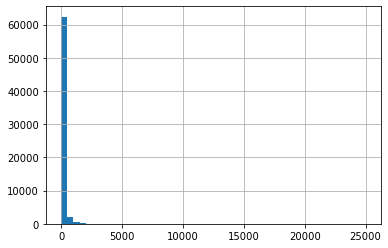

In [141]:
data["price"].hist(bins=50)

<AxesSubplot:>

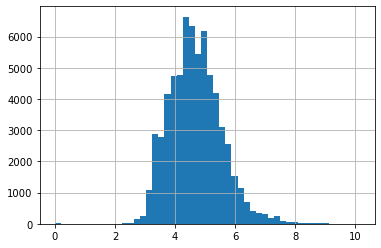

In [142]:
np.log1p(data["price"]).hist(bins=50)

### numerical features distributions and scales

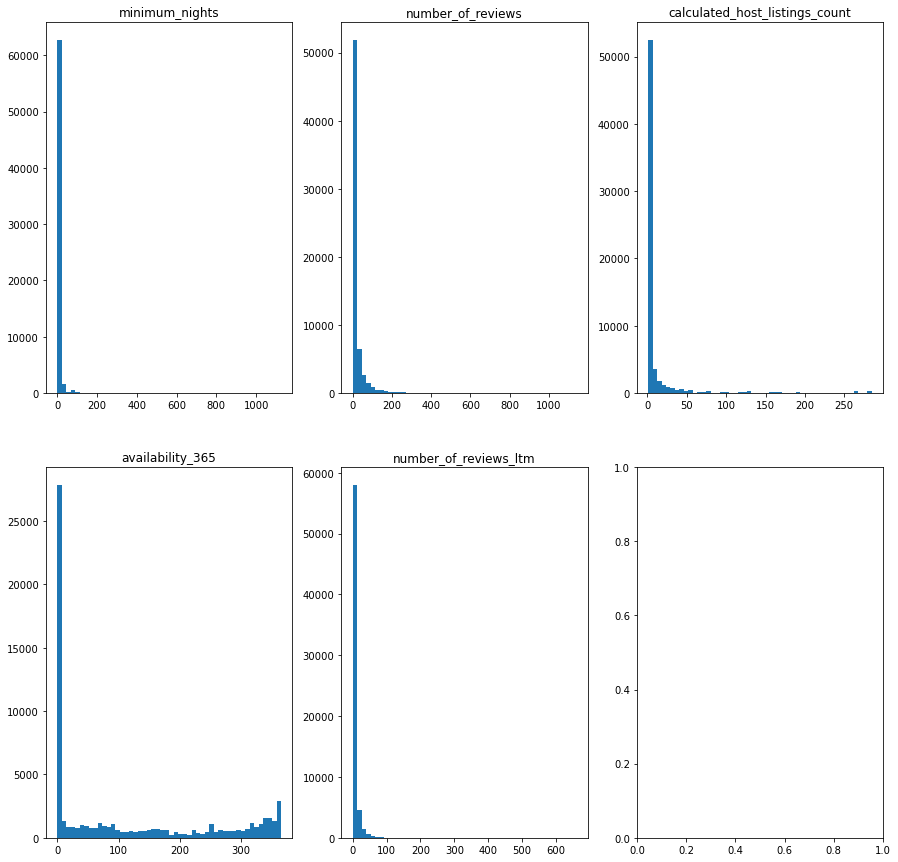

In [143]:


num_features = ["minimum_nights", "number_of_reviews", "calculated_host_listings_count", 
                    "availability_365", "number_of_reviews_ltm" ]

fig, axes = plt.subplots(2, 3, figsize=(15, 15))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

axes_ = ax1, ax2, ax3, ax4, ax5 

for ax, feature in zip(axes_ , num_features):
    
    ax.hist(data[feature], bins = 50)    
    ax.set_title(feature)

plt.show()

<AxesSubplot:>

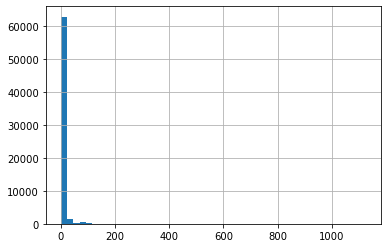

In [144]:
data["minimum_nights"].hist(bins=50)

<AxesSubplot:>

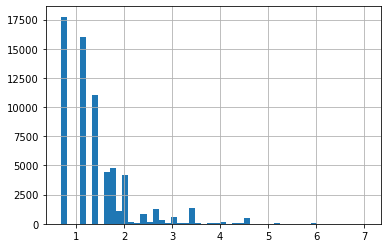

In [145]:
np.log1p(data["minimum_nights"]).hist(bins=50)

### median price by neighbourhood and room type

In [146]:
data.groupby("neighbourhood")["price"].median().reset_index().sort_values("price", ascending=False) \
                .rename(columns={"price":"median_price"}).reset_index(drop=True)[:10]

,neighbourhood,median_price
0,City of London,192.5
1,Kensington and Chelsea,190.0
2,Westminster,181.0
3,Camden,129.0
4,Hammersmith and Fulham,117.0
5,Islington,100.0
6,Richmond upon Thames,100.0
7,Wandsworth,100.0
8,Southwark,95.0
9,Hackney,91.0


Top 5 neighbourhoods median prices : 
- City of London
- Kensington and Chelsea
- Westminster
- Camden
- Hammersmith and Fulham

In [147]:
data.groupby("room_type")["price"].median().reset_index().sort_values("price", ascending=False) \
                .rename(columns={"price":"median_price"}).reset_index(drop=True)

,room_type,median_price
0,Hotel room,205
1,Entire home/apt,150
2,Private room,50
3,Shared room,39


In [149]:
data["room_type"].value_counts(normalize=True)

Entire home/apt    0.609938
Private room       0.380280
Shared room        0.006123
Hotel room         0.003659
Name: room_type, dtype: float64

- highest median price for Hotel room and Entire home/apt
- class frequencies: 0,36 % for hotel rooms and 60 % for Entire home/apt

In [360]:
data["price"] = np.log1p(data["price"] )

In [361]:
from sklearn.model_selection import train_test_split

In [362]:
df_full_train, df_test = train_test_split(data, test_size = 0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=1)

In [363]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [364]:
y_train = df_train['price']
y_val = df_val['price']
y_test = df_test['price']

In [365]:
del df_train['price']
del df_val['price']
del df_test['price']

In [366]:
df_train

,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,Greenwich,51.477338,0.016947,Private room,5,0,1,71,0
1,Tower Hamlets,51.526100,-0.050720,Private room,2,2,1,0,0
2,Lambeth,51.468110,-0.121020,Private room,2,19,1,163,16
3,Hackney,51.535230,-0.055183,Entire home/apt,3,0,7,52,0
4,Barnet,51.588280,-0.201260,Entire home/apt,1,32,1,313,3
...,...,...,...,...,...,...,...,...,...
41596,Haringey,51.591800,-0.070590,Entire home/apt,3,0,1,0,0
41597,Southwark,51.505038,-0.087458,Private room,1,14,8,38,14
41598,Westminster,51.521950,-0.173020,Entire home/apt,90,5,11,275,3
41599,Lambeth,51.435096,-0.113473,Private room,1,0,1,50,0


In [367]:
df_train_dict = df_train.to_dict(orient='records')
df_val_dict = df_val.to_dict(orient='records')
df_test_dict = df_test.to_dict(orient='records')

In [368]:
dv = DictVectorizer(sparse=False)

In [369]:
X_train = dv.fit_transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

In [370]:
dv.get_feature_names()

['availability_365',
 'calculated_host_listings_count',
 'latitude',
 'longitude',
 'minimum_nights',
 'neighbourhood=Barking and Dagenham',
 'neighbourhood=Barnet',
 'neighbourhood=Bexley',
 'neighbourhood=Brent',
 'neighbourhood=Bromley',
 'neighbourhood=Camden',
 'neighbourhood=City of London',
 'neighbourhood=Croydon',
 'neighbourhood=Ealing',
 'neighbourhood=Enfield',
 'neighbourhood=Greenwich',
 'neighbourhood=Hackney',
 'neighbourhood=Hammersmith and Fulham',
 'neighbourhood=Haringey',
 'neighbourhood=Harrow',
 'neighbourhood=Havering',
 'neighbourhood=Hillingdon',
 'neighbourhood=Hounslow',
 'neighbourhood=Islington',
 'neighbourhood=Kensington and Chelsea',
 'neighbourhood=Kingston upon Thames',
 'neighbourhood=Lambeth',
 'neighbourhood=Lewisham',
 'neighbourhood=Merton',
 'neighbourhood=Newham',
 'neighbourhood=Redbridge',
 'neighbourhood=Richmond upon Thames',
 'neighbourhood=Southwark',
 'neighbourhood=Sutton',
 'neighbourhood=Tower Hamlets',
 'neighbourhood=Waltham Forest'

## Baseline: mean price of training set

In [371]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [372]:
y_train.shape, y_val.shape

((41601,), (13868,))

In [375]:
y_train_pred_baseline = np.full((41601, ), y_train.mean()) 
y_val_pred_baseline = np.full((13868, ), y_train.mean()) 

In [376]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred_baseline)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred_baseline)))

train rmse: 0.8854949364084743
val rmse: 0.8974071213217006


In [167]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred_baseline)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred_baseline)))

train rmse: 0.8655108360532652
val rmse: 0.866230341112585


## Linear regression

In [377]:
from sklearn.linear_model import LinearRegression

In [378]:
lr = LinearRegression()

In [379]:
lr.fit(X_train, y_train)

LinearRegression()

In [380]:
lr.coef_

array([ 1.55483381e-03,  6.03960246e-03, -2.36037219e-01,  4.01746996e-01,
       -4.79921490e-04, -2.82570171e-01,  4.58072441e-03, -4.18406507e-01,
        1.32735264e-01, -2.01130900e-01,  2.41845490e-01,  2.84457207e-01,
       -3.65873182e-01,  2.56205595e-02, -1.68355943e-01, -1.28040025e-01,
        1.38034956e-02,  2.03180885e-01, -7.01637354e-02, -6.66970078e-02,
       -2.64732085e-01, -7.07156891e-02,  1.06536451e-02,  1.16468843e-01,
        4.90240816e-01,  1.15160644e-01,  4.46781075e-02, -2.44459420e-01,
        1.03158533e-01, -2.31987459e-02, -1.58516961e-01,  2.20189428e-01,
        1.96139018e-01, -2.11950546e-01,  1.46702567e-02, -1.89351974e-01,
        1.63082539e-01,  4.83497437e-01, -9.96054564e-04,  1.52122299e-03,
        6.00956097e-01,  1.93061610e-01, -2.54502504e-01, -5.39515203e-01])

In [381]:
y_train_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

In [382]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.6266260417463104
val rmse: 0.6342940127293721


In [183]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.6115103503046886
val rmse: 0.6120429207467899


## Decision Tree

In [383]:
dt = DecisionTreeRegressor(max_depth=6)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6)

In [384]:
dt.feature_importances_, dv.feature_names_

(array([1.42094951e-01, 2.02967326e-01, 3.34711489e-03, 1.15128657e-02,
        4.76945867e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.55264304e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.17340325e-03,
        2.68535341e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.32004318e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.71683805e-02, 2.56945224e-02, 7.15596278e-03,
        5.30697229e-01, 2.00949996e-03, 0.00000000e+00, 1.97557807e-03]),
 ['availability_365',
  'calculated_host_listings_count',
  'latitude',
  'longitude',
  'minimum_nights',
  'neighbourhood=Barking and Dagenham',
  'neighbourhood=Barnet',
  'neighbourhood=Bexley',
  'neig

availability_365, room_type=Entire home/apt and calculated_host_listings_count have highest feature importance coefficients: 0.62, 0.15, and 0.098

In [385]:
y_train_pred = dt.predict(X_train)
y_val_pred = dt.predict(X_val)

In [386]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.5764460349190912
val rmse: 0.5877282986510768


In [170]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.5896572675652801
val rmse: 0.5972778811629801


## Random Forest

In [387]:
from sklearn.ensemble import RandomForestRegressor

In [388]:
rf = RandomForestRegressor(n_estimators=30, max_depth=8)

In [389]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=30)

In [390]:
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

In [391]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.5309941726435078
val rmse: 0.5557818265747893


In [255]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.5501208199321762
val rmse: 0.5698251906884635


## Xgboost

In [403]:
xgb = XGBRegressor(max_depth=6)

In [404]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [405]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

In [406]:
print("train rmse:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("val rmse:", np.sqrt(mean_squared_error(y_val, y_val_pred)))

train rmse: 0.4382797800888744
val rmse: 0.51549544706801


## Predict with xgboost on test data

In [466]:
i = 90

In [467]:
dict_ = df_test.iloc[i].to_dict()

In [468]:
dict_trans = dv.transform(dict_)

In [469]:
y_pred = xgb.predict(dict_trans)[0]
np.exp(y_pred) -1

72.46707153320312

In [470]:
np.exp(y_test.iloc[i]) -1

58.000000000000014